# 단순 선형 회귀
## 1. 패키지 준비

In [2]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split # 데이터를 훈련용과 테스트용으로 나누는 기능
from tensorflow.keras.models import Sequential       # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense            # 모델 객체에 학습층을 쌓기 위한 클래스

## 2. 데이터셋 준비

In [3]:
origin = read_excel('https://data.hossam.kr/E04/cars.xlsx')
origin.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## 3. 데이터 전처리
- 결측치 확인

In [4]:
origin.isna().sum()

speed    0
dist     0
dtype: int64

> 결측치 없음

## 4. 탐색적 데이터 분석
- 기본 통계 확인

In [5]:
origin.describe()

,speed,dist
count,50.000000,50.000000
mean,15.400000,42.980000
std,5.287644,25.769377
min,4.000000,2.000000
25%,12.000000,26.000000
50%,15.000000,36.000000
75%,19.000000,56.000000
max,25.000000,120.000000


- 산점도 그래프와 추세선 확인

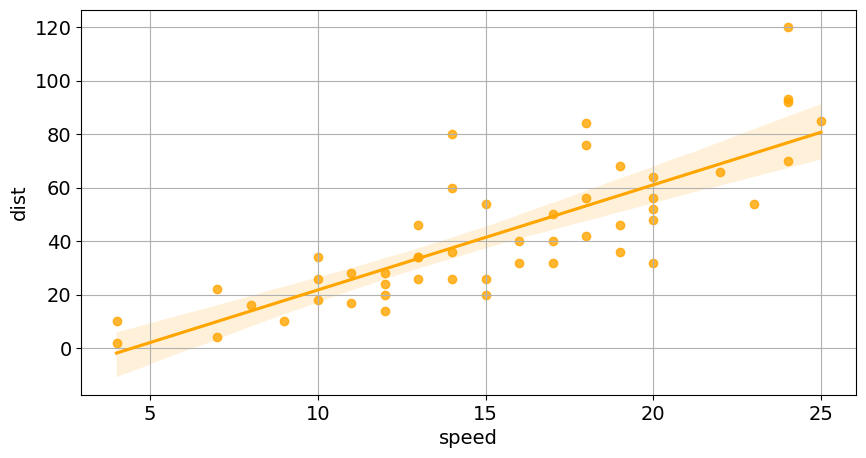

In [6]:
plt.figure(figsize = (10, 5))
sb.regplot(data=origin,
           x='speed',
           y='dist',
           color= 'orange')
plt.grid()
plt.show()
plt.close()

> 곡선보다는 `선형분포`에 더 가까우므로 `단순선형회귀모델`을 적용하기로 결정

## 5. 데이터셋 분할
- 랜덤 시드 고정

In [7]:
np.random.seed(777)

- 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [8]:
x = origin.drop(['dist'], axis=1)
y = origin['dist']
print('훈련데이터 크기:', x.shape, ' / 레이블 크기:', y.shape)

훈련데이터 크기: (50, 1)  / 레이블 크기: (50,)


- 훈련 데이터와 검증 데이터로 분할

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=777)

print('훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d' % (len(x_train), len(x_test)))

훈련용 데이터셋 크기: 35, 검증용 데이터셋 크기: 15


## 6. (학습 )모델 개발
- 모델 정의

In [10]:
my_model = Sequential()

# 1차원의 데이터를 입력으로 받고, 32개의 출력을 가지는 첫 번째 Dense층
my_model.add(Dense(32, 
                   activation = 'relu',
                   input_shape = (1,)))
# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 확성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함
my_model.add(Dense(1, activation='linear'))

my_model.compile(optimizer = 'adam',
                 loss = 'mse',
                 metrics = ['mae'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 학습하기
    - loss = 훈련 데이터 손실률
    - mae = 훈련 절대오차
    - val_loss = 검증 데이터 손실률
    - val_mae = 검증 절대오차

In [11]:
result = my_model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))

# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500


2/2 [==============================] - 0s 90ms/step - loss: 2494.5886 - mae: 42.5458 - val_loss: 1732.0735 - val_mae: 36.0091
Epoch 2/500
2/2 [==============================] - 0s 15ms/step - loss: 2475.0361 - mae: 42.3568 - val_loss: 1718.9302 - val_mae: 35.8467
Epoch 3/500
2/2 [==============================] - 0s 16ms/step - loss: 2458.0593 - mae: 42.1779 - val_loss: 1706.1945 - val_mae: 35.6887
Epoch 4/500
2/2 [==============================] - 0s 16ms/step - loss: 2440.8752 - mae: 42.0027 - val_loss: 1693.4147 - val_mae: 35.5294
Epoch 5/500
2/2 [==============================] - 0s 17ms/step - loss: 2423.5842 - mae: 41.8253 - val_loss: 1680.6300 - val_mae: 35.3693
Epoch 6/500
2/2 [==============================] - 0s 18ms/step - loss: 2407.1008 - mae: 41.6506 - val_loss: 1668.3373 - val_mae: 35.2147
Epoch 7/500
2/2 [==============================] - 0s 16ms/step - loss: 2389.7654 - mae: 41.4754 - val_loss: 1656.4083 - val_mae: 35.0640
Epoch 8/500
2/2 [=============================

,loss,mae,val_loss,val_mae
epochs,,,,
1,2494.588623,42.545792,1732.073486,36.009136
2,2475.036133,42.356773,1718.930176,35.846733
3,2458.059326,42.177902,1706.194458,35.688663
4,2440.875244,42.002655,1693.414673,35.529354
5,2423.584229,41.825336,1680.630005,35.369278
...,...,...,...,...
496,272.557953,13.046261,252.074493,13.156528
497,272.500092,13.047814,252.006546,13.152125
498,272.500946,13.045745,251.948074,13.148346


## 7. 학습 결과 평가
- 학습 결과 시각화

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

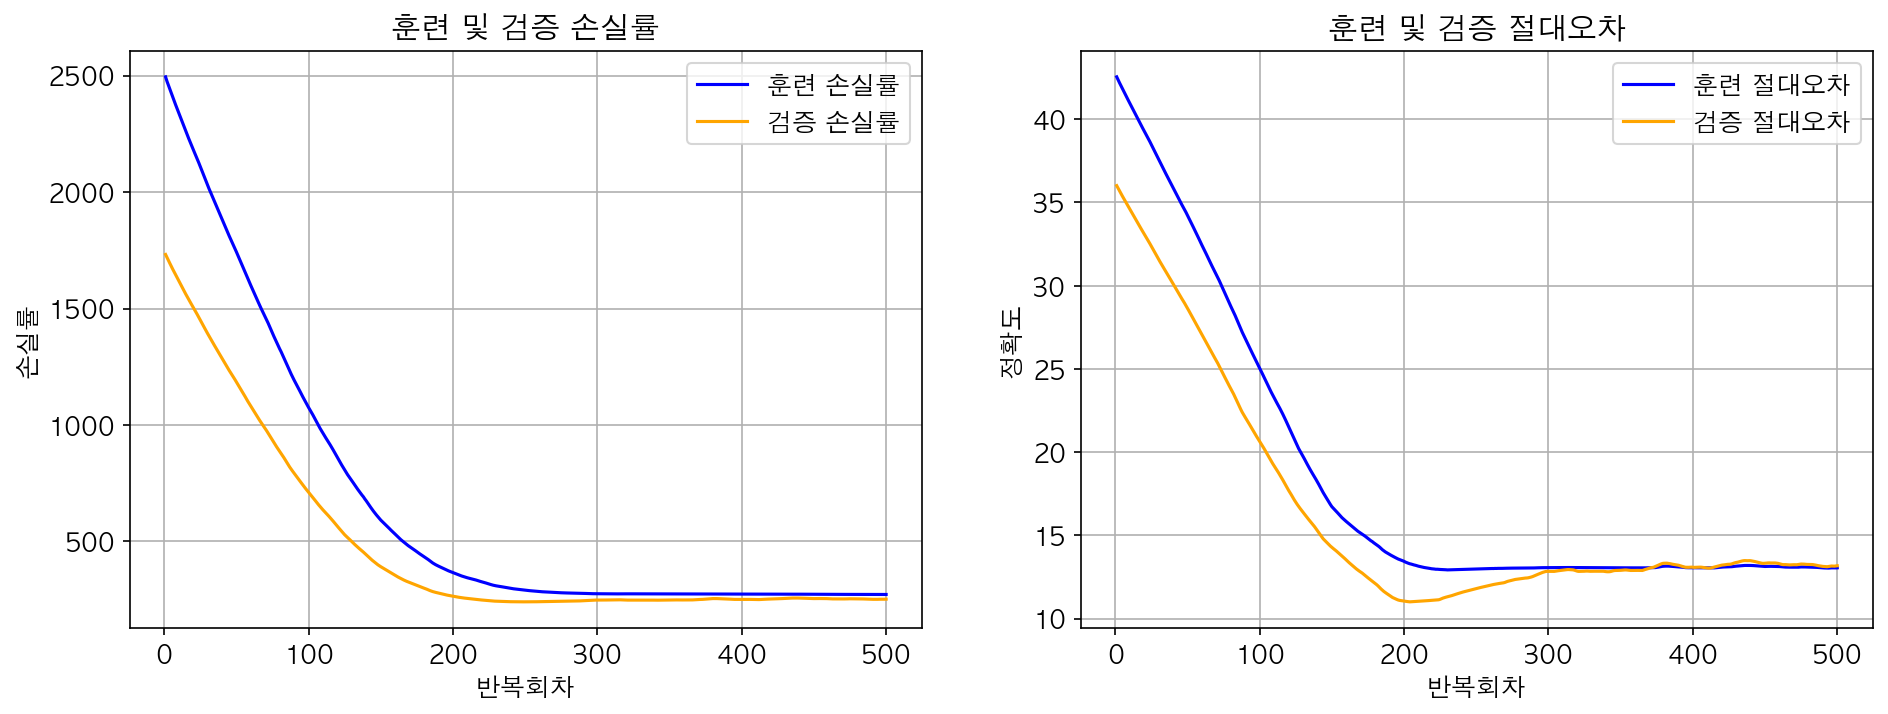

In [12]:
# 그래프 기본 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
sb.lineplot(x=result_df.index, y='mae', data=result_df, color='blue', label='훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color='orange', label='검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

- 모델 성능 평가

In [13]:
evaluate1 = my_model.evaluate(x_train, y_train)
print('최종 훈련 손실룰: %f, 최종 훈련 절대오차: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = my_model.evaluate(x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 절대오차: %f' % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 2ms/step - loss: 272.4510 - mae: 13.0533
최종 훈련 손실룰: 272.450989, 최종 훈련 절대오차: 13.053309
1/1 [==============================] - 0s 13ms/step - loss: 252.3133 - mae: 13.1733
최종 검증 손실률: 252.313278, 최종 검증 절대오차: 13.173340


## 8. 학습 결과 적용
- 테스트 데이터에 대한 `예측 결과 산정`

In [14]:
results = my_model.predict(x_test)
print(results)

1/1 [==============================] - 0s 57ms/step
[[67.55577 ]
 [38.932503]
 [36.07018 ]
 [33.207855]
 [56.106464]
 [41.79483 ]
 [41.79483 ]
 [53.24414 ]
 [36.07018 ]
 [56.106464]
 [41.79483 ]
 [58.968792]
 [21.758547]
 [38.932503]
 [13.171569]]


- `결과 데이터셋 구성`

In [15]:
kdf = DataFrame({'검증데이터': x_test['speed'],
                 '실제값': y_test,
                 '예측값': results.flatten()})

kdf['예측오차'] = kdf['실제값'] - kdf['예측값']
kdf

,검증데이터,실제값,예측값,예측오차
44,23,54,67.555771,-13.555771
17,13,34,38.932503,-4.932503
11,12,14,36.070179,-22.070179
9,11,17,33.207855,-16.207855
36,19,46,56.106464,-10.106464
21,14,60,41.794830,18.205170
22,14,80,41.794830,38.205170
31,18,42,53.244141,-11.244141
12,12,20,36.070179,-16.070179
37,19,68,56.106464,11.893536


- `실제 결과값`과 `머신러닝에 의한 예측값` 비교

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

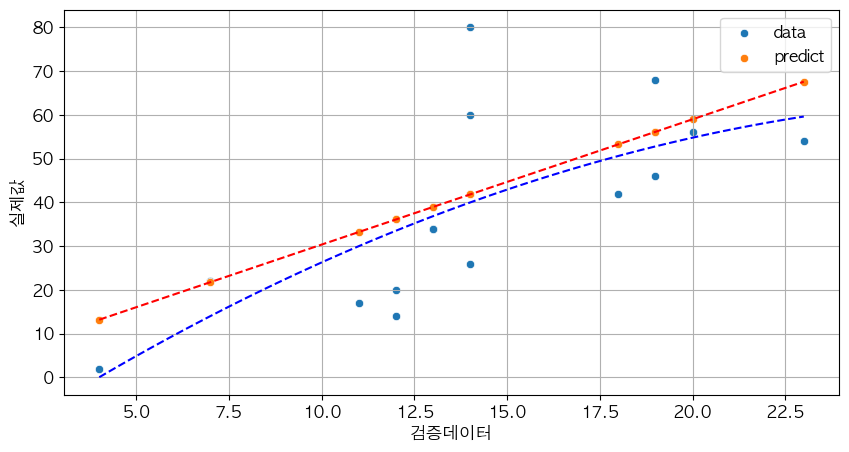

In [16]:
helper.regplot(x_left=kdf['검증데이터'],
               y_left=kdf['실제값'],
               y_left_pred=kdf['예측값'])

- `임의의 값`에 대한 `머신러닝 예측 결과`

In [17]:
my_speed = 50
results = my_model.predict([[my_speed]])
print('속도가 %d인 자동차의 제동거리는 %d로 예상됩니다.' % (my_speed, results))

1/1 [==============================] - 0s 23ms/step
속도가 50인 자동차의 제동거리는 144로 예상됩니다.


/var/folders/md/0jpjv9rd2qg156cjt56sczy80000gn/T/ipykernel_15580/2731861476.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('속도가 %d인 자동차의 제동거리는 %d로 예상됩니다.' % (my_speed, results))
